# Devoir 3 (solution): MCMC & OOP

## Exercice 1

In [1]:
distr <- function(density, parameters, name) {
    stopifnot(is.function(density),
              is.list(parameters),
              is.character(name))

    structure(list(density = density,
                   parameters = parameters,
                   name = name),
              class = "distr")
}

dens <- function(d, y, x, log, ...) UseMethod("dens")

dens.distr <- function(d, y, x = NULL, log = FALSE, ...)
    do.call(d[["density"]],
            c(y = y, x = x, log = log, d[["parameters"]]))

print.distr <- function(x, ...) {
    cat(x[["name"]], "\n")

    for (name in names(x[["parameters"]]))
        cat(name, "=", x[["parameters"]][[name]], "\n")
}

In [2]:
ber <- distr(\(y, ...) dbinom(x = y, size = 1L, ...),
             list(prob = 0.75),
             "Bernoulli 3/4")

In [3]:
ber

Bernoulli 3/4 
prob = 0.75 

In [4]:
dens(ber, 0.0)

[1] 0.25

In [5]:
dens(ber, 0.0, log = TRUE)

[1] -1.386294

In [6]:
dens(ber, -42.0, log = TRUE)

[1] -Inf

# Exercice 2

In [7]:
kern <- function(density, parameters, name, sampler) {
    stopifnot(is.function(sampler))

    structure(c(distr(density, parameters, name),
                sampler = sampler),
              class = c("kern", "distr"))
}

rand <- function(d, n, x, ...) UseMethod("rand")

rand.kern <- function(d, n, x, ...)
    do.call(d[["sampler"]], c(n = n, x = x, d[["parameters"]]))

In [8]:
gauss <- kern(\(y, x, ...) dnorm(x = y, mean = x, ...),
              list(sd = 1.0),
              "Normale mean = x, sd = 1",
              \(n, x, ...) rnorm(n, mean = x, ...))

In [9]:
dens(gauss, 0.6, 0.0)

[1] 0.3332246

In [10]:
dens(gauss, 0.6, 3.0)

[1] 0.02239453

In [11]:
dens(gauss, 0.6, 0.0, log = TRUE)

[1] -1.098939

In [12]:
rand(gauss, 10, x = 0)

[1]  0.22191926  0.93674520  0.73892606  0.70332840 -0.29111733 -0.30982414
 [7]  0.03229286  0.99840539  2.14039124 -0.21158781

In [13]:
rand(gauss, 10, x = 3)

[1] 2.387856 2.879274 3.678381 3.465378 3.910683 2.585471 2.598656 3.820390
 [9] 1.331395 3.143226

# Exercice 3

In [14]:
mhsampler <- function(target, proposal) {
    stopifnot("distr" %in% class(target),
              "kern" %in% class(proposal))

    structure(list(target = target,
                   proposal = proposal),
              class = "mhsampler")
}

aratio <- function(sampler, y, x, log, ...) UseMethod("aratio")

aratio.mhsampler <- function(sampler, y, x, log = FALSE, ...) {
    logπ <- \(x) dens(sampler[["target"]], y = x, log = TRUE)
    logq <- \(y, x) dens(sampler[["proposal"]], y = y, x = x, log = TRUE)

    logα <- logπ(y) + logq(x, y) - logπ(x) - logq(y, x)

    if (!log)
        return(exp(logα))
    logα
}

rand.mhsampler <- function(sampler, n, init = 0.0, ...) {
    prop <- \(n, x = x) rand(sampler[["proposal"]], n = n, x = x)

    x <- init
    replicate(n, {
        y <- prop(1, x)

        logα <- aratio(sampler, y, x, log = TRUE)

        if (log(runif(1)) <= logα)
            x <<- y

        x
    })
}

In [15]:
expo <- distr(\(y, ...) dexp(x = y, ...),
              list(rate = 1),
              "Exponentielle rate = 1")

In [16]:
mh_rexpo <- mhsampler(expo, gauss)

In [17]:
rand(mh_rexpo, 25)

[1] 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.7113361 0.7113361 0.7113361 0.2231450 0.2231450 0.2231450 0.2231450
[15] 0.2231450 0.2231450 0.2231450 0.3281203 0.3281203 0.3281203 0.3281203
[22] 1.2677178 1.1065008 2.3511543 2.8616172

# Exemples

## Exponentielle, noyeau gaussien

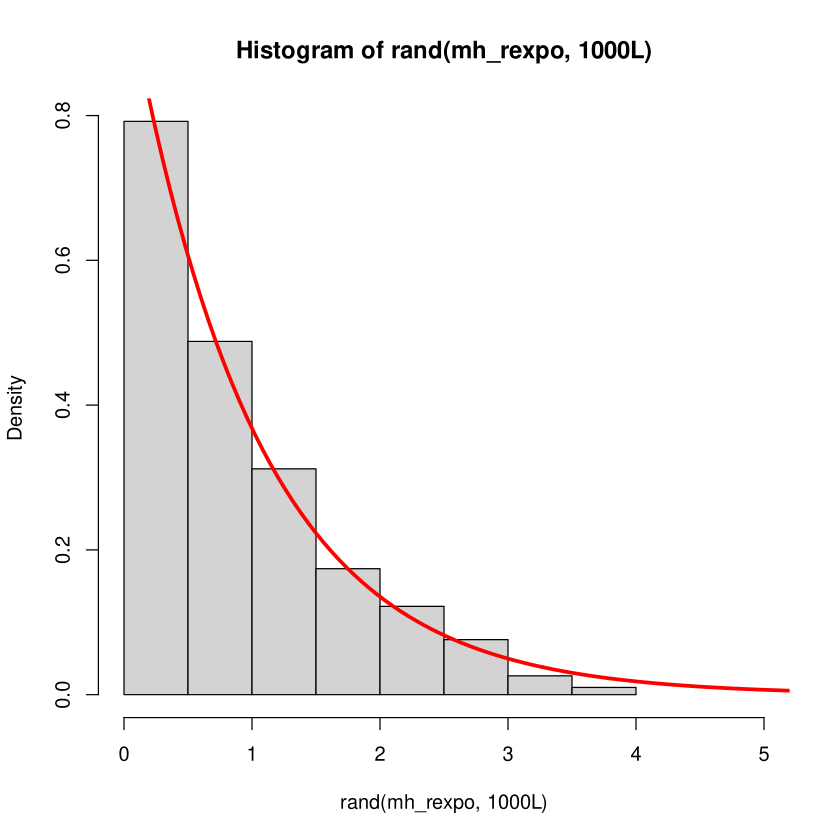

In [18]:
hist(rand(mh_rexpo, 1e3L), prob = TRUE,
     xlim = c(0.0, 5.0))
curve(dexp(x), from = 0L, to = 6L,
      add = TRUE, lwd = 3L, col = "red")

## T, noyeau gaussien

In [19]:
tdistr <- distr(\(y, ...) dt(x = y, ...),
                list(df = 2.0),
                "T 1")

In [20]:
mh_t <- mhsampler(tdistr, gauss)

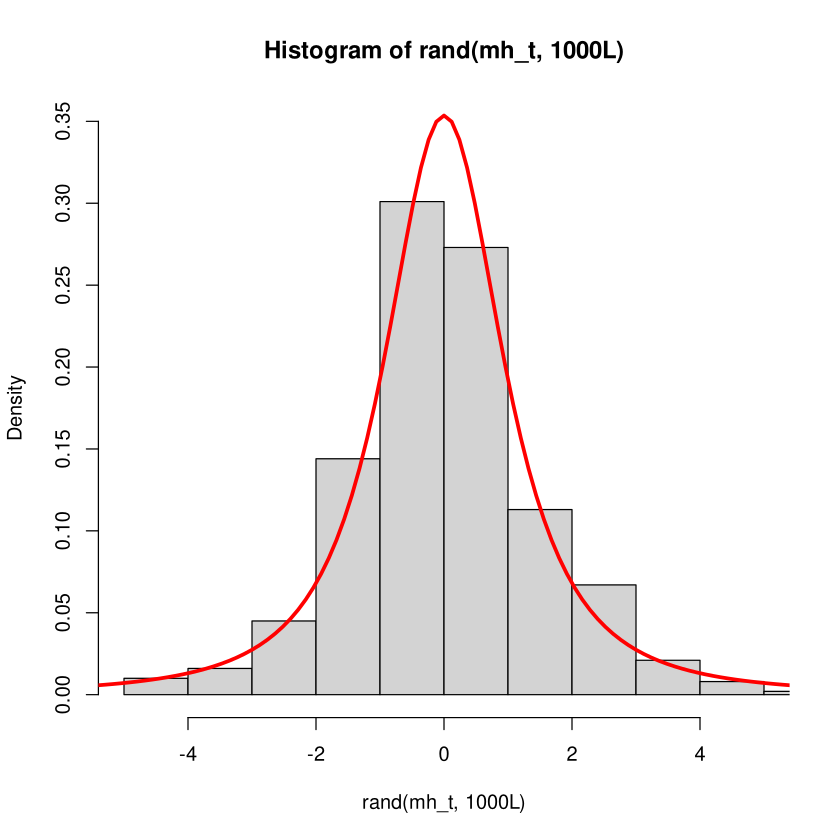

In [21]:
hist(rand(mh_t, 1e3L), prob = TRUE,
     xlim = c(-5.0, 5.0), ylim = c(0.0, 0.35))
curve(dt(x, df = tdistr[["parameters"]][["df"]]), from = -6, to = 6L,
      add = TRUE, lwd = 3L, col = "red")